<a href="https://colab.research.google.com/github/Hendrixetumah/Titanic-Survival-Prediction/blob/main/notebooks/Titanic_Survival_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TITANIC SURVIVAL PREDICTION MODEL**

## The objective of this project is to develop a robust machine learning model capable of accurately predicting which Titanic passengers survived.

The RMS Titanic, often simply known as the Titanic, was launched on May 31, 1911. She embarked on her maiden voyage from Southampton, England, on April 10, 1912, carrying 2,240 passengers and crew. Tragically, only five days into the journey, she struck an iceberg, broke apart, and ultimately sank to the bottom of the Atlantic Ocean.

### *The data for this project is sourced from Kaggle competitions.* [Data for this project can be downloaded here](https://www.kaggle.com/competitions/titanic/data)

In [34]:
# I have already downloaded the CSV files for the datasets to my local device, and I will import them here.
# If needed, you can also download the training dataset using the link provided above.

from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [35]:
# Import all modules needed for this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

In [36]:
# This will ensure all data rows and column are shown

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [37]:
# Read our csv file and save as a Dataframe named df and inspect the first 5 rows

df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
#Show the shape of the data

df.shape

(891, 12)

As we can see, our dataset has 891 rows and 12 columns. We will further inspect the data by viewing the column names, and a summary description of the dataset.

In [39]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

A description of these column values is available [here](https://www.kaggle.com/competitions/titanic/data)

In [40]:
# A brief statistical summary of our dataset

df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Wrangling and Exploratory Data Analysis

First we check for any missing values

In [41]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


We can further visualize this by plotting a heatmap using the seaborn library.

<Axes: >

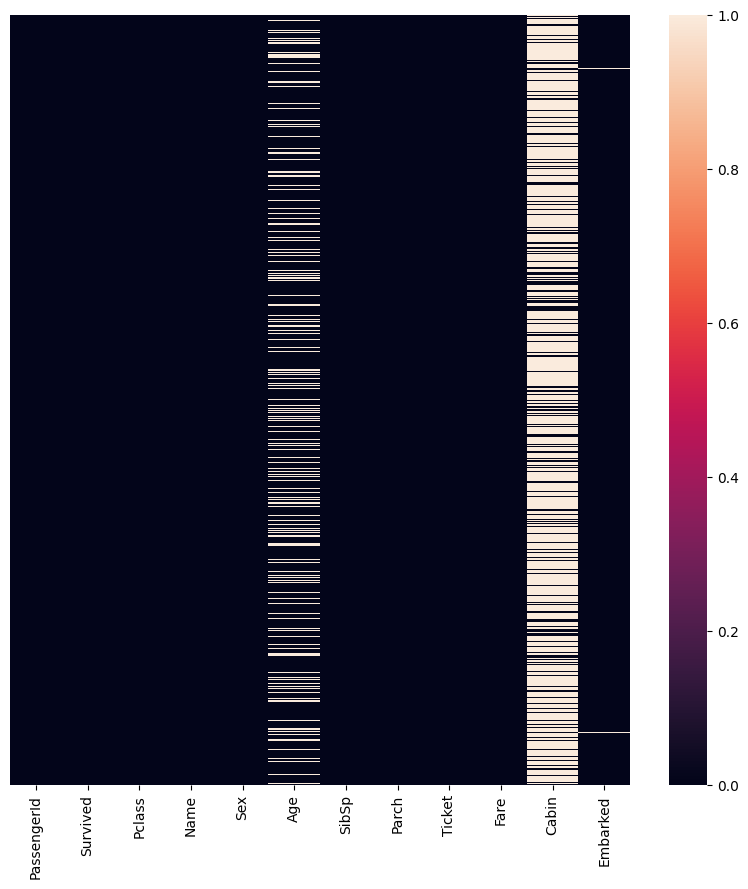

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull(),yticklabels=False,cbar=True)

We can see that out dataset has missing values in the Age, Cabin and Embarked column

We must address these missing values. The Age column contains 177 missing entries, accounting for roughly 20% of its total observations. As a result, dropping this column entirely would not be an ideal solution.

One might consider replacing all missing values in the Age column with the mean or median of the available ages. However, this approach may not accurately reflect the true distribution of ages, especially given the presence of outliers. A density plot of the Age column clearly reveals that the majority of passengers fall within the 20 to 40 age range (see visualization below).

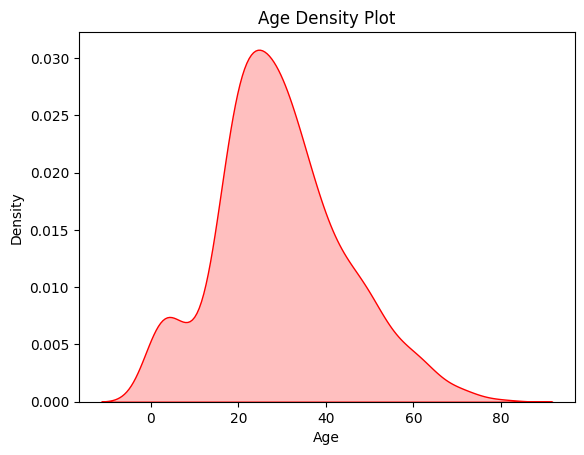

In [43]:
# Kde plot

sns.kdeplot(df['Age'], fill=True, color='red')
plt.title('Age Density Plot')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In [44]:
# To check if there are outliers in our Age column

# Temporarily drop all null values that may hinder our statistical calculations and assign them to a new variable df_age_no_null

df_age_no_null = df.dropna(subset=['Age'])

Q1 = df_age_no_null['Age'].quantile(0.25)
Q3 = df_age_no_null['Age'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - IQR * 1.5
upper_bound = Q3 + IQR * 1.5

outliers = df_age_no_null[(df_age_no_null['Age'] < lower_bound) | (df_age_no_null['Age'] > upper_bound)]
outliers.shape[0]

11

We clearly observe 11 outliers in the age column, and the density plot reveals an uneven frequency distribution. Therefore, I will segment the passengers by age and gender into four groups. First, I will extract the title from each passenger's name into a new column and then group these titles into corresponding age ranges (for example, categorizing ages 0–12 as "child"). After removing all outliers, I will compute the mean for each age group and replace all null values with the respective group’s mean.

In [45]:
# Firstly we extract title (Mr, Mrs, Miss, etc.) from passenger names and store in a new column we will name 'Title'


df['Title'] = df['Name'].str.extract(r',\s*(\w+)\.')

# Now we have our Title column, we will create another column to hold the grouped Title, we will call it Title_grouped. Note that these new columns are created to help us find the mean of each age group. We will drop them later

# Firstly, we replace all null values (if exist) in the title column with 'Unknown' and then group all passengers according to title
df['Title'].fillna('Unknown', inplace=True)


# I noticed that the title Miss was used to refer to both female children and also female young adults, so I had to explicitly assign all passengers with the title 'Miss" whose age is 12 or less to be grouped as 'Child'
# I then merged this 'Child' group to all passengers with title 'Master' as master is used to refer to male children. So all passengers less than or equal to 12 years will be grouped as 'Child'


# Grouping Titles using lists
adult_men = ['Mr', 'Rev', 'Capt', 'Col', 'Dr', 'Don', 'Jonkheer', 'Major', 'Sir']
married_women = ['Mrs', 'Ms', 'Lady', 'Mme']
unmarried_women = ['Miss', 'Mlle']
child = ['Master']


# Map Titles based on lists
def group_title(title, age):
    if title in adult_men:
        return 'Adult Men'
    elif title in married_women:
        return 'Married Women'
    elif title in unmarried_women:
        if age <= 12:
            return 'Child'
        else:
            return 'Unmarried Women'
    elif title in child:
        return 'Child'
    else:
        return 'Unknown'

# Apply the grouping function
df['Title_Grouped'] = df.apply(lambda row: group_title(row['Title'], row['Age']), axis=1)


# We previously found out there are outliers in our Age column. So we will define a function to remove outliers and calculate the mean for all age groups

def remove_outliers(series):
    series = series.dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Calculate the average age for each Title Group after excluding outliers
title_mean_ages = df.groupby('Title_Grouped')['Age'].apply(remove_outliers).dropna().groupby(level=0).mean()


# Fill in missing Age values using the mean age of each corresponding age group
df['Age'] = df.apply(lambda row: title_mean_ages[row['Title_Grouped']] if pd.isnull(row['Age']) and row['Title_Grouped'] in title_mean_ages else row['Age'], axis=1)

# Check if there are still any null values in the Age column
df['Age'].isnull().sum()

0

With all missing values in the Age column now filled, we can proceed to address the missing values in the Cabin column.

The Cabin column contains 687 missing values—approximately 77% of its observations. Naturally, the first instinct might be to drop this column entirely and exclude it from our model.

In [46]:
df.drop(columns=['Cabin'], inplace=True)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Title_Grouped'],
      dtype='object')

We move on to the Embarked column.

This column has only 2 missing values, I will just replace missing values with the mode of the column.

In [47]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Embarked'].isnull().sum()

0

With all missing values addressed, our next step is to verify the data types of every column to ensure they are correctly configured.

In [48]:
df.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


Although all columns are of the correct type, some are not useful for our model—namely, Passenger ID, Name, Ticket, and Title_Grouped. To preserve the original data, we'll create a copy of our dataframe for further processing and then drop these irrelevant columns from the copy.

In [49]:
df_model = df.copy()
df_model.drop(columns=['PassengerId', 'Name', 'Ticket', 'Title_Grouped'], inplace=True)
df_model.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')

With only nine columns remaining, we can now perform exploratory data analysis to uncover the relationships among these variables. Since our target variable is Survived, we'll specifically visualize its interactions with the other columns.

### Relationship between Pclass and Survived

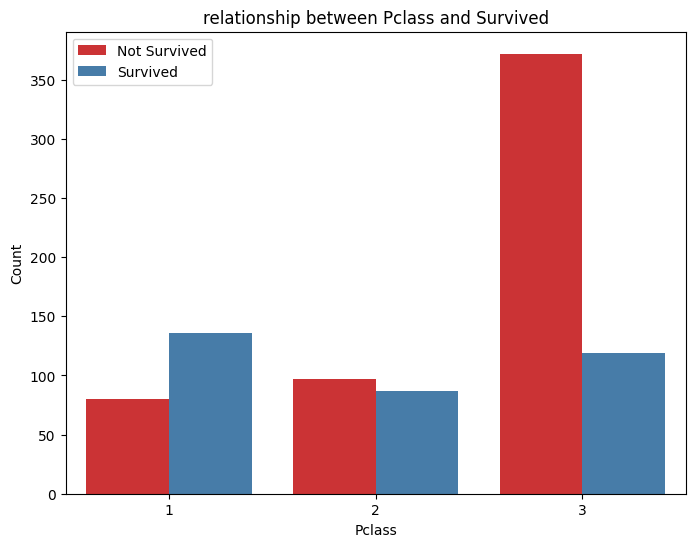

In [50]:
plt.figure(figsize=(8,6))

sns.countplot(x='Pclass', hue='Survived', data=df_model, palette='Set1')

plt.title('relationship between Pclass and Survived')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.show()

The data clearly indicate that first-class passengers experienced a significantly higher survival rate compared to those in other classes, making passenger class a critical predictor variable.

### Relationship between Sex and Survived

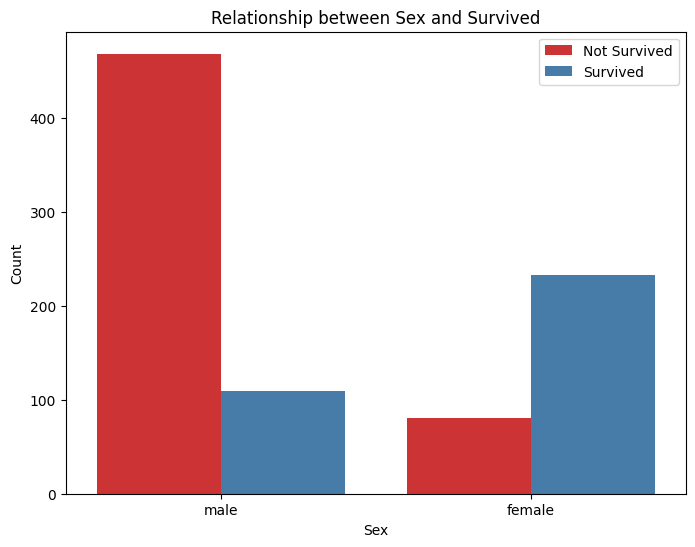

In [51]:
plt.figure(figsize=(8,6))

sns.countplot(x='Sex', hue='Survived', data = df_model, palette='Set1')
plt.title('Relationship between Sex and Survived')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.show()

The visualization clearly indicates that females experienced a significantly higher survival rate than males, establishing gender as a crucial predictor variable.

### Relationship between Age and Survived

For improved context and clarity, we begin by categorizing the Age values into three groups: Child (less than 13 years of age), Adult (13 - 50 years), and Senior Adult (defined as individuals over 50 years of age).

In [52]:
# Categorize Age into three distinct groups to create the 'Age_group' feature
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 13, 50, (df['Age'].max())], labels=['Child', 'Adult', 'Senior Adult'], include_lowest = True)


Then we plot the relationship between Age_Group and Survived

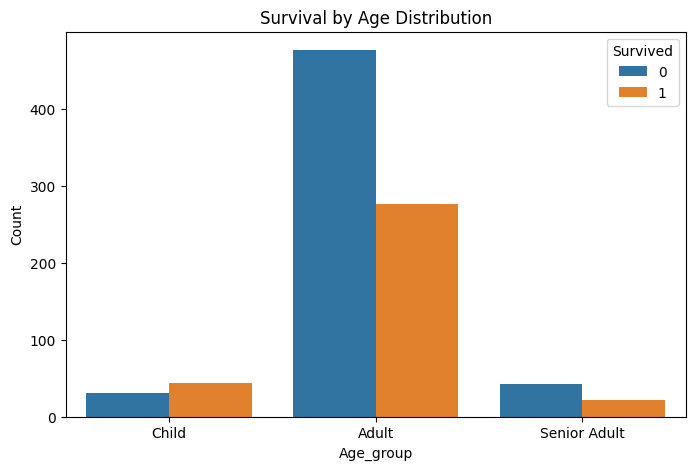

In [53]:
plt.figure(figsize=(8, 5))

sns.countplot(x = 'Age_Group', hue='Survived', data=df)

plt.xlabel("Age_group")
plt.ylabel("Count")
plt.title("Survival by Age Distribution")

plt.show()


The visualization reveals that the majority of passengers fall into the Adult category (ages 13 to 50), and a significant number of these adults did not survive. Additionally, most Senior Adults (passengers over 50) also experienced high mortality rates, whereas children (under 14) generally fared better.

To further explore our data, we should create an additional visualization that examines the relationship between the Fare and Survived variables.

### Relationship between Fare and Survived

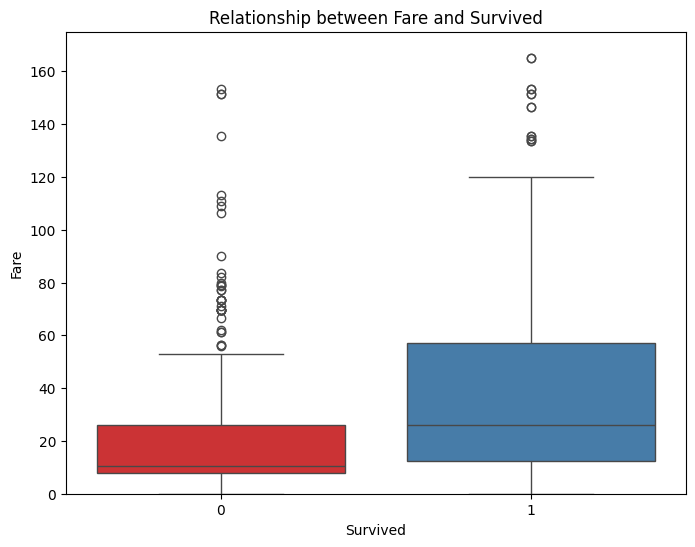

In [54]:
plt.figure(figsize=(8,6))

sns.boxplot(x='Survived', y='Fare', data=df_model, palette='Set1')

plt.ylim(0, 175)
plt.title('Relationship between Fare and Survived')
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.show()

The visualization indicates that passengers who paid higher fares were more likely to survive compared to those who paid lower fares. Although there are some outliers in this distribution, we will further explore the Fare feature to gain deeper insights into its overall pattern and impact.

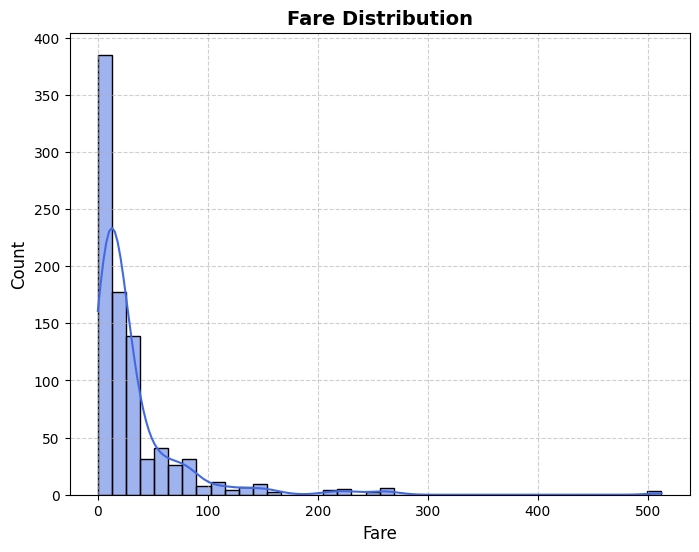

In [55]:
# plot a histplot to learn about the distribution of the Fare feature

plt.figure(figsize=(8, 6))

sns.histplot(df_model['Fare'], bins=40, kde=True, color="royalblue", edgecolor="black")

plt.xlabel("Fare", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Fare Distribution", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

The distribution of values in our Fare feature is clearly non-normal; to improve model performance, we need to transform it so that it approximates a Gaussian distribution.

We apply a logarithmic transformation to the Fare column values to reshape the distribution into a more Gaussian form.

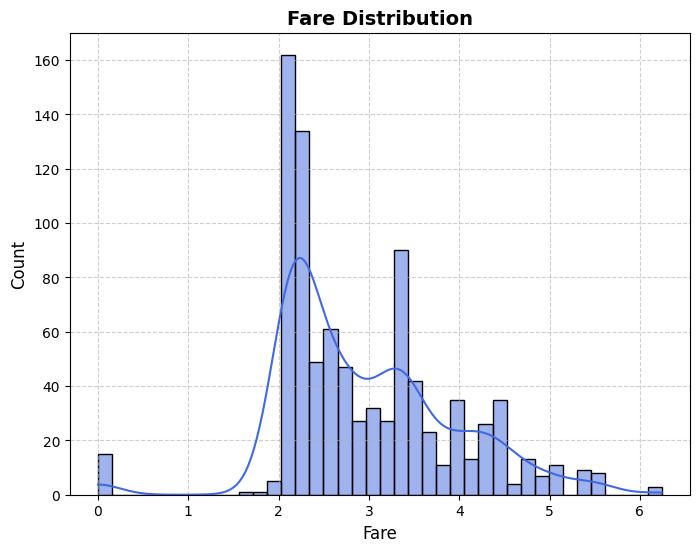

In [56]:
# log transformation
df_model['Fare'] = np.log1p(df_model['Fare'])

#display the distribution to check the result of our log transformation
plt.figure(figsize=(8, 6))

sns.histplot(df_model['Fare'], bins=40, kde=True, color="royalblue", edgecolor="black")

plt.xlabel("Fare", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Fare Distribution", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

We can now observe a more balanced and symmetric distribution curve, indicating that the log transformation has effectively normalized the data.

Our dataset is now meticulously cleaned and fully prepared for the model development phase.

In [57]:
df_model.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,2.110213,S,Mr
1,1,1,female,38.0,1,0,4.280593,C,Mrs
2,1,3,female,26.0,0,0,2.188856,S,Miss
3,1,1,female,35.0,1,0,3.990834,S,Mrs
4,0,3,male,35.0,0,0,2.202765,S,Mr


We define our target variable y and predictor variables X

In [58]:
y = df_model['Survived']
X = df_model.drop(columns=['Survived'])

In [59]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [60]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,22.0,1,0,2.110213,S,Mr
1,1,female,38.0,1,0,4.280593,C,Mrs
2,3,female,26.0,0,0,2.188856,S,Miss
3,1,female,35.0,1,0,3.990834,S,Mrs
4,3,male,35.0,0,0,2.202765,S,Mr


## MODEL DEVELOPMENT

### After constructing and evaluating multiple classification models, I selected the best-performing one based on my evaluation metrics. For clarity and brevity, only this optimal model is presented in the notebook.

### Logistic Regression Model

Optimized Feature Preprocessing

In [61]:
# Define categorical and numerical features for preprocessing

categorical_features = ['Sex', 'Embarked', 'Title']
numerical_features = ['Age', 'Pclass', 'Fare', 'SibSp', 'Parch']

# Define lists of features that require scaling and one-hot encoding
transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]

# Apply feature-specific preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(transformers)

Splitting Data into Training and Testing Sets & Establishing the Pipeline

In [62]:
# Train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Define an integrated pipeline to streamline both preprocessing and model development

Inputs = [('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))]

pipeline = Pipeline(Inputs)

# Perform 5-fold cross-validation on the training data to assess model performance
cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='accuracy')

# Display the baseline cross-validation score to evaluate initial model performance
print("Baseline Cross-Validation Accuracy: {:.4f}".format(np.mean(cv_scores)))

Baseline Cross-Validation Accuracy: 0.8203


We employ GridSearchCV to systematically explore and identify the optimal hyperparameters for our Logistic Regression model.

In [63]:
# Grid search parameters

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Define the grid search and fit the training data

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)


# Get the best model and test on the test set
best_model = grid_search.best_estimator_


Y_pred = best_model.predict(X_test)
Y_proba = best_model.predict_proba(X_test)[:, 1]


# Compute the roc_auc_score
auc_roc = roc_auc_score(Y_test, Y_proba)



# Print the best hyperparameters, the best cross-validation score, the test set accuracy, the AUC-ROC score, and the full classification report

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Test Accuracy: {:.4f}".format(accuracy_score(Y_test, Y_pred)))
print("AUC-ROC Score:", auc_roc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Best Parameters:  {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Score:  0.8216684723726978
Test Accuracy: 0.8492
AUC-ROC Score: 0.870223978919631
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



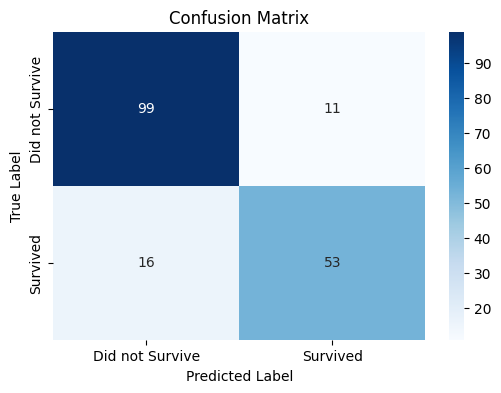

In [64]:
# Visualize the confusion matrix to gain further insight into model performance

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Did not Survive', 'Survived'], yticklabels=['Did not Survive', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Train the Final Model on the Entire Dataset to Preserve All Information

In [65]:
# Train final model on all data

cv_scores = cross_val_score(best_model, X, y, cv=5)

# Set C to 1 to optimize regularization when training on the entire dataset

best_model.set_params(classifier__C=1)
best_model.fit(X, y)

# test on test set.
Y_pred = best_model.predict(X_test)
Y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the roc_auc_score
auc_roc = roc_auc_score(Y_test, Y_proba)


# Print the best hyperparameters, the best cross-validation score, the test set accuracy, the AUC-ROC score, and the full classification report

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Test Accuracy: {:.4f}".format(accuracy_score(Y_test, Y_pred)))
print("AUC-ROC Score:", auc_roc)
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Best Parameters:  {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Score:  0.8216684723726978
Test Accuracy: 0.8436
AUC-ROC Score: 0.880764163372859
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       110
           1       0.82      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



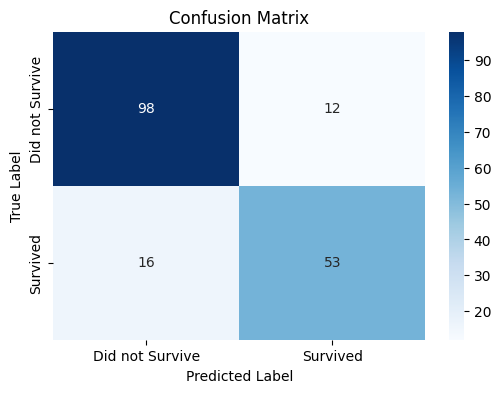

In [66]:
# Visualize the confusion matrix to gain further insight into model performance

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Did not Survive', 'Survived'], yticklabels=['Did not Survive', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Despite training on the full dataset to preserve all available information, the model's accuracy score experienced a slight decrease.

###Summary

For this project, I employed a Logistic Regression model, which achieved an accuracy of approximately 85% on the test set. I plan to further refine the model, and future updates will document the enhancements and improved performance.

*Please feel free to let me know if you identify any errors or areas for improvement in this model.*

# THANK **YOU**

Author: Hendrix Etumah

Data Scientist and Machine Learning Engineer